# Titania Coatings - Post-Experiment Data Analysis
This program is to take in data collected by the DAQ unit and output the results of that data, including plots and reductions

Jesse Mendoza   
August 2017

## Preface
When calling script from bash, include filename and the times that the UV light was turned on and when reduction stopped, in the following format. Please follow it exactly, punctuation and spaces and all: 

\>> python PostExperimentDataAnalysis.py 'experimentdata.csv' '2:30PM-2:55PM' '3:15PM-3:43PM'

## A. Retrieve and set-up data

In [27]:
import sys
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt   #https://docs.python.org/3/library/datetime.html
import seaborn as sns
import os
import plotly
import pylab
import matplotlib.text as t


In [28]:
# Get file and its data and prepare for pandas dataframe

#filename = sys.argv[1]
#filename = '1-19-17 CE-CERT.csv'
filename = 'Titania 5-10 Ferro(5) 50-50.csv'
header_size=8


def data_no_header(filename,header_size):
    dataset = open(filename,'r')
    dataset = list(csv.reader(dataset))
    dataset = dataset[header_size:]
    return dataset


dataset = pd.DataFrame(data_no_header(filename,header_size),columns =['Sample Number','Date&Time','NOx','NO','Events'])

print(dataset.head(3))

  Sample Number                   Date&Time       NOx        NO      Events
0             1  05/10/2017 10:23:30.436 AM   -0.4456    0.0476   DAQ Start
1             2  05/10/2017 10:23:30.936 AM   -0.4822   -0.0354        None
2             3  05/10/2017 10:23:31.436 AM   -0.3552   -0.0110        None


In [29]:
# Convert Date&Time string to datetime object
#https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior


def conv_daq_to_datetime_format(dt_row):
    split_dt_row = dt_row.split(' ')
    split_dt_second = split_dt_row[1].split('.')
    formatted_daq_time = dt.datetime.strptime(split_dt_second[0]+' '+split_dt_row[2],'%I:%M:%S %p')
    return formatted_daq_time


formatted_dt = []
for row in dataset['Date&Time']:
    formatted_row = conv_daq_to_datetime_format(row)
    formatted_dt.append(formatted_row)
    
dataset['Formatted DT'] = formatted_dt

print(dataset['Formatted DT'].head(3))


0   1900-01-01 10:23:30
1   1900-01-01 10:23:30
2   1900-01-01 10:23:31
Name: Formatted DT, dtype: datetime64[ns]


In [30]:
# Get how many experiments were conducted and at what times

#reduction_times = sys.argv[2:]
#reduction_times = ['2:14PM-2:32PM','3:09PM-3:22PM','3:51PM-4:05PM'] #OG
#reduction_times = ['2:15PM-2:20PM','3:10PM-3:16PM','3:53PM-3:57PM']
reduction_times = ['10:28AM-10:48AM']


def conv_timearg_to_dt(timearg):
    split_timearg = timearg.split('-')
    ss1 = split_timearg[0]
    ss2 = split_timearg[1]
    ss1_formatted = dt.datetime.strptime(ss1,'%I:%M%p')
    ss2_formatted = dt.datetime.strptime(ss2,'%I:%M%p')
    return ss1_formatted,ss2_formatted


formatted_reduction_times = []
for time in reduction_times:
    formatted_time = conv_timearg_to_dt(time)
    formatted_reduction_times.append(formatted_time)

print(formatted_reduction_times)

[(datetime.datetime(1900, 1, 1, 10, 28), datetime.datetime(1900, 1, 1, 10, 48))]


In [31]:
def get_duration(dt_object_col):
    # returns duration in minutes starting from 0
    dur_col=[]
    time0 = dt_object_col[0].hour*60 + dt_object_col[0].minute + dt_object_col[0].second/60
    for row in dt_object_col:
        dur = row.hour*60 + row.minute + row.second/60 - time0
        dur_col.append(dur)
    return dur_col


In [32]:
def conv_to_ppb(no,nox):
    # no and nox represent columns of the raw no and nox daq data (in voltages)
    #returns values converted to ppb from calibration
    conv_no=[]
    conv_nox=[]
    for i,row in enumerate(no):
        dq_no = row
        dq_nox = nox[i]
        converted_no = 99.437*float(dq_no) - 7.5526
        converted_nox = 99.626*float(dq_nox) + 0.66
        conv_no.append(converted_no)
        conv_nox.append(converted_nox)
    return conv_no,conv_nox


converted_ppb = conv_to_ppb(dataset['NO'], dataset['NOx'])
dataset['conv_NO'] = converted_ppb[0]
dataset['conv_NOx'] = converted_ppb[1]
print(dataset['conv_NO'].head(4),'\n',dataset['conv_NOx'].head(4))


#Moving avg
win = 60 #moving window (in seconds) 
dataset['conv_NO_smooth'] = dataset['conv_NO'].rolling(window=win,win_type='boxcar').mean()
dataset['conv_NOx_smooth'] = dataset['conv_NOx'].rolling(window=win,win_type='boxcar').mean()
print(dataset['conv_NO_smooth'][25:35])


0    -2.819399
1   -11.072670
2    -8.646407
3     7.860135
Name: conv_NO, dtype: float64 
 0   -43.733346
1   -47.379657
2   -34.727155
3   -30.353574
Name: conv_NOx, dtype: float64
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
Name: conv_NO_smooth, dtype: float64


In [33]:
class Experiments():
    #Creates instance for each experiment
    '''
    methods:
    self.name
    self.ss1
    self.ss2
    self.dataset
    self.duration
    self.no/x_max
    self.no/x_min
    self.no/x_reduction
    '''
    
    def __init__(self):
        #self.name = name
        return
    

    def filt_times(self,exp_times,margin):
        #filter out times not within experiment, times in dt format, margin argument in minutes
        self.ss1 = exp_times[0]
        self.ss2 = exp_times[1]
        marg = dt.timedelta(seconds=margin*60)
        
        self.dataset = dataset[dataset['Formatted DT'] > (self.ss1-marg)]
        self.dataset = self.dataset[dataset['Formatted DT'] < (self.ss2+marg)]


    def get_duration(self,dt_col):
        dur_col = []
        time0 = dt_col.iloc[0]
        for row in dt_col:
            dur = row-time0
            duration = dur.seconds/60
            dur_col.append(round(float(duration),2))
        self.duration = dur_col


    def kinetics(self):
        #1 - min/max
        self.no_max = self.dataset['conv_NO_smooth'].max()
        self.nox_max = self.dataset['conv_NOx_smooth'].max()
        self.no_min = self.dataset['conv_NO_smooth'].min()
        self.nox_min = self.dataset['conv_NOx_smooth'].min()
        self.no_reduction = 1-(self.no_min/self.no_max)
        self.nox_reduction = 1-(self.nox_min/self.nox_max)
        

In [34]:
# Create class instance for each experiment
exp_nums=['Exp1','Exp2','Exp3','Exp4','Exp5','Exp6','Exp7','Exp8']

exps = [Experiments() for i in range(len(formatted_reduction_times))]
for i,exp in enumerate(exps):
    times = formatted_reduction_times[i]
    exp.filt_times(times,0)
    exp.get_duration(exp.dataset['Formatted DT'])
    exp.kinetics()
    exp.name=exp_nums[i]


/Users/Owner/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## B. Plot data

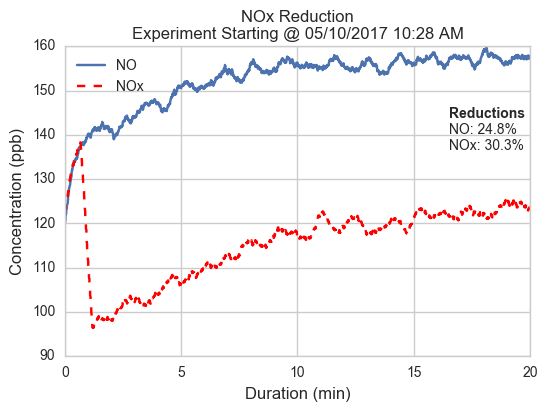

In [35]:
# Make plots

for exp in exps:
    sns.set_style('whitegrid')
    
    start_dt = str(exp.dataset['Date&Time'].iloc[0][0:16])+''+str(exp.dataset['Date&Time'].iloc[0][23:])
    plt.title('NOx Reduction\n'+'Experiment Starting @ '+ start_dt)
    
    no=plt.plot(exp.duration,exp.dataset['conv_NO_smooth'],label='NO')
    nox=plt.plot(exp.duration,exp.dataset['conv_NOx_smooth'],label='NOx',color='r',linestyle='--')
    
    plt.xlabel('Duration (min)',size=12)
    plt.ylabel('Concentration (ppb)',fontsize=12)
    
    plt.legend(loc='best')

    plt.figtext(0.765,0.72,'Reductions', weight='bold')
    plt.figtext(0.765,0.68,'NO: '+str(round(exp.no_reduction*100,1))+'%')
    plt.figtext(0.765,0.64,'NOx: '+str(round(exp.nox_reduction*100,1))+'%')
    
    save_filename = str(start_dt[0:10]+'_'+exp.name).replace('/','-')
    pylab.savefig('/Users/Owner/Google Drive/Titania/Data/plots/'+save_filename)
    
    plt.show()

## C. Save results

In [36]:
# Create file with all relevant information


In [37]:
# Move products to appropriate directory

In [38]:
# Upload data to s3